# Three investigators - part II

A project for scraping and analysing data from a fan site on the audio book called '[The three investigators](https://en.wikipedia.org/wiki/Three_Investigators#Germany)'

Part II: Analysis

- additional data cleaning and preparing for analysis
- using [Genderize API](https://github.com/SteelPangolin/genderize) to predict gender of actors using first names
- descriptive analysis of data
- prediction of episode ratings

# Setup

In [1]:
#python version used for this project
from platform import python_version
print(python_version())

3.7.5


In [22]:
# import modules [as specified in requirements.txt]
import pandas as pd
import numpy as np
import re
import requests
from datetime import date

# for file directories
import os

%matplotlib inline

In [3]:
#change directory to root folder
os.chdir("..")

In [4]:
#load script to work with Genderize API (download [here](https://github.com/SteelPangolin/genderize))
#this will require to have requests imported
from src.genderize import Genderize

# Load data

In [78]:
meta = pd.read_csv(".\\data\\scraped\\meta.csv")
actors = pd.read_csv(".\\data\\scraped\\actor_all.csv")
content = pd.read_csv(".\\data\\scraped\\content_all.csv")
rating = pd.read_csv(".\\data\\scraped\\rating.csv")

In [71]:
meta.shape

(205, 44)

# Data cleaning and prep

## Consistent column labels

In [99]:
# make all column names lower case
df_list = [meta, actors, content, rating]

for df in df_list:
    df.columns = df.columns.str.lower()

## Predict actors' gender

In [7]:
#get gender for list of firstnames from Genderize.io

#get unique list of first actor names
names_unique = list (set (actors["Firstname"]))

#access genderize.io api using this repository: tps://github.com/SteelPangolin/genderize
gender_raw = Genderize().get(names_unique)

#make dictionary into data frame
gender = []
for i in range(len(gender_raw)):
    c = pd.DataFrame(gender_raw[i].items())[1]
    gender.append(c)

#rename columns
gender = pd.concat(gender, axis=1).transpose().rename(columns={0:"Name", 1:"Gender", 2:"Gender_probability", 3:"Gender_count"})  

#save output as backup to access later
gender.to_csv(".\\data\\processed\\actor_gender_prediction_" + "%s" %(str(date.today())) + ".csv") 

#display
gender.head()

,Name,Gender,Gender_probability,Gender_count
1,Moritz,male,0.99,4088
1,Gabi,female,0.64,17867
1,Nadja,female,0.97,8845
1,Igmar,male,0.88,43
1,Ulli,male,0.53,1419


In [79]:
# join tables
actors = pd.merge(actors, gender, left_on='Firstname', right_on = "Name", how="left")
actors = actors.drop("Name", axis=1)
actors.head()

,Role,Actor,ID,Actor_clean,Title,Firstname,Surename,No_names,Main_actor,Narrator,Gender,Gender_probability,Gender_count
0,Hitchcock,Peter Pasetti,1,Peter Pasetti,0,Peter,Pasetti,2,0,1,male,0.99,165452
1,Justus Jonas,Oliver Rohrbeck,1,Oliver Rohrbeck,0,Oliver,Rohrbeck,2,1,0,male,0.99,32776
2,Peter Shaw,Jens Wawrczeck,1,Jens Wawrczeck,0,Jens,Wawrczeck,2,1,0,male,0.99,23807
3,Bob Andrews,Andreas Fröhlich,1,Andreas Fröhlich,0,Andreas,Fröhlich,2,1,0,male,0.99,71365
4,"Mr. Fentriss, Schriftsteller",Richard Lauffen,1,Richard Lauffen,0,Richard,Lauffen,2,0,0,male,0.99,101928


## Add to meta data

In [80]:
## Create year and month column
meta["Year"] = pd.DatetimeIndex(meta['Date']).year
meta["Month"] = pd.DatetimeIndex(meta["Date"]).month

### Number of actors, main and side

In [81]:
actors_agg = pd.DataFrame(actors.groupby("ID")[["Actor", "Main_actor", "Narrator"]].agg(
    {"Actor": "count", "Main_actor":"sum", "Narrator": "max"})).reset_index()
actors_agg = actors_agg.rename(columns={"Actor":"No_actors_total", "Main_actor":"No_main_actors"})
actors_agg["No_side_actors"] = actors_agg["No_actors_total"] - actors_agg["No_main_actors"] - actors_agg["Narrator"] #also remove narrator

#join with meta
meta = pd.merge(meta, actors_agg, left_on="ID" ,right_on="ID")

### Gender balance all actors

In [82]:
actors_gender = actors.groupby(["ID", "Gender"])["Role"].count()
actors_gender = pd.DataFrame(actors_gender).unstack().fillna(0).reset_index("ID")
actors_gender.columns = actors_gender.columns.droplevel(level=0)
actors_gender = actors_gender.rename(columns={"": "ID", "female": "no_female_actors", "male": "no_male_actors"})

#join with meta
meta = pd.merge(meta, actors_gender, left_on="ID" ,right_on="ID")

#gender missing
meta["no_actor_gender_missing"] = meta["no_actors_total"] - meta[["no_female_actors", "no_male_actors"]].sum(axis=1)

#gender balance for all actors
meta["female_actors_ratio"] = meta["no_female_actors"] / meta[["no_female_actors", "no_male_actors"]].sum(axis=1) *100

### Gender balance side actors

In [87]:
filter_side_actors = (actors["Narrator"] == 0) & (actors["Main_actor"] == 0)
side_actors_gender = actors.loc[filter_side_actors].groupby(["ID", "Gender"])["Role"].count()
side_actors_gender = pd.DataFrame(side_actors_gender).unstack().fillna(0).reset_index("ID")
side_actors_gender.columns = side_actors_gender.columns.droplevel(level=0)
side_actors_gender = side_actors_gender.rename(columns={"": "ID", "female": "no_female_side_actors", "male": "no_male_side_actors"})

#join with meta
meta = pd.merge(meta, side_actors_gender, left_on="ID" ,right_on="ID")

#gender balance for side actors
meta["female_side_actors_ratio"] = meta["no_female_side_actors"] / meta[["no_female_side_actors", "no_male_side_actors"]].sum(axis=1) *100

In [96]:
meta.columns = meta.columns.str.lower()

In [97]:
meta.columns

Index(['id', '"anudhara" aufgenommen bei bantree records, worms / produzent',
       'buch', 'buch und effekte', 'buch und redaktion', 'cover-illustration',
       'coverillustration', 'design', 'effekte und redaktion',
       'erscheinungsdatum', 'erzählt von', 'geräusche', 'ger�usche',
       'hörspielbearbeitung', 'klang-recycling', 'laufzeit', 'musik',
       'musik und effekte',
       'nessie der seltsame wecker matthias green recyclings aus 3 fragezeichen rap',
       'produktion und regie', 'projektleitung und produktmanagement',
       'redaktion', 'redaktion und geräusche', 'regie', 'regie und produktion',
       'song', 'teil a erzählt von', 'teil b erzählt von',
       'teil c erzählt von', 'titel', 'titelmusik', 'html',
       'zur vorherigen folge | zur nächsten folge', 'book', 'cover', 'music',
       'director', 'editor', 'sounds', 'date', 'minutes', 'minutes_mean',
       'minutes_total', 'parts', 'year', 'month', 'no_actors_total',
       'no_main_actors', 'narrator',

# Explorative Analysis

## Chronology

In [15]:
years = meta.groupby("Year")[["Parts", "Minutes_mean", "ID"]].agg({
    "Parts": ["sum"], "Minutes_mean" : ["mean", "min", "max"], "ID": ["count","first", "last"]})
years.columns = ["_".join(x) for x in years.columns.ravel()]
years = years.reset_index().rename(columns={"Minutes_mean_mean": "Minutes_mean",
                              "Minutes_mean_min": "Minutes_min", "Minutes_mean_max":"Minutes_max"}) 
years.head()

,Year,Parts_sum,Minutes_mean,Minutes_min,Minutes_max,ID_count,ID_first,ID_last
0,1979,9,45.555556,43.0,50.0,9,1,9
1,1980,12,42.416667,38.0,49.0,12,10,21
2,1981,6,43.666667,41.0,49.0,6,22,27
3,1982,2,42.000000,40.0,44.0,2,28,30
4,1983,3,43.666667,40.0,49.0,3,31,33


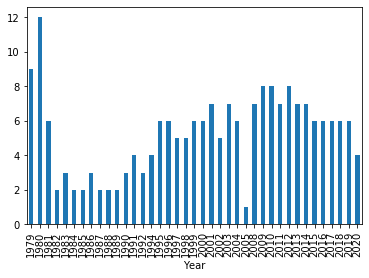

In [26]:
#number of episodes over time
years.set_index("Year")["ID_count"].plot(kind='bar')

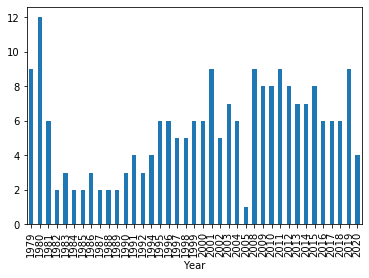

In [36]:
#number of episodes over time
years.set_index("Year")["Parts_sum"].plot(kind='bar')

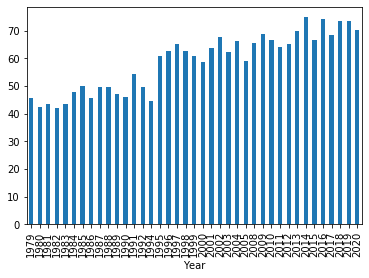

In [25]:
#Average length over time
years.set_index("Year")["Minutes_mean"].plot(kind='bar')

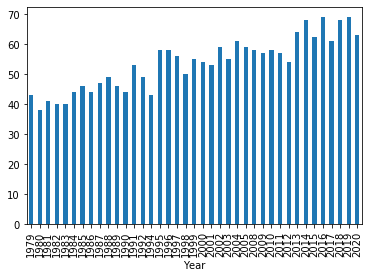

In [29]:
#Average length over time
years.set_index("Year")["Minutes_min"].plot(kind='bar')

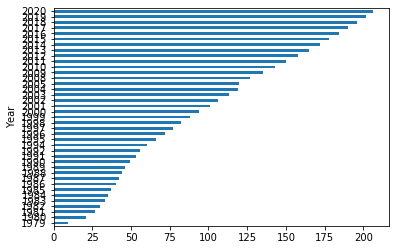

In [37]:
#number of episodes over time
years.set_index("Year")["ID_last"].plot(kind='barh')

## Gender

In [41]:
## calculate gender roles by episode
no_main = (actors["Narrator"] == 0) & (actors["Main_actor"] == 0)
gender_balance = actors.loc[no_main].groupby(["ID", "Gender"])["Role"].count()
gender_balance = pd.DataFrame(gender_balance).unstack().fillna(0).reset_index("ID")
gender_balance.columns = gender_balance.columns.droplevel(level=0)
gender_balance["total"] = gender_balance[["female", "male"]].sum(axis=1)
gender_balance["female_ratio"] = round(gender_balance["female"] / gender_balance["total"] * 100, 1)
gender_balance = gender_balance.rename(columns={"": "ID"})
gender_balance

Gender,ID,female,male,total,female_ratio
0,1,2.0,6.0,8.0,25.0
1,2,3.0,7.0,10.0,30.0
2,3,1.0,7.0,8.0,12.5
3,4,0.0,11.0,11.0,0.0
4,5,3.0,6.0,9.0,33.3
...,...,...,...,...,...
201,202,2.0,4.0,6.0,33.3
202,203,3.0,3.0,6.0,50.0
203,204,2.0,5.0,7.0,28.6
204,205,5.0,8.0,13.0,38.5


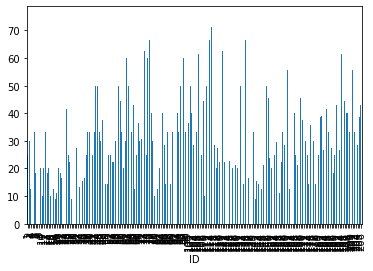

In [42]:
#number of episodes over time
gender_balance.set_index("ID")["female_ratio"].plot(kind='bar')